# VQEによる量子化学計算

このチュートリアルでは、Amazon Braket で PennyLane を使用して量子化学の重要な問題、すなわち分子の基底状態エネルギーを見つける方法を説明します。この問題は、変分量子固有値ソルバー (Variational Quantum Eigensolver; VQE) アルゴリズムを実装することにより、NISQ ハードウェアを利用して解くことができます。量子化学と VQE の詳細については、[Braket VQE ノートブック](../Hybrid_quantum_algorithms/vqe_Chemistry/vqe_Chemistry_braket.ipynb) や [PennyLane チュートリアル](https://pennylane.ai/qml/demos/tutorial_qubit_rotation.html) を参考にして下さい。

<div class="alert alert-block alert-info">
<b>注:</b> このノートブックの実行には pennylane>=0.18 以上と amazon-braket-pennylane-plugin>=1.5.0 が必要です。
</div>

## 量子化学から量子回路へ

まず最初のステップは、量子化学の問題を量子コンピュータで扱えるよう変換することです。PennyLane では ``qchem`` パッケージを使います。ローカルマシン上で実行している場合、``qchem`` パッケージは [これら](https://pennylane.readthedocs.io/en/stable/introduction/chemistry.html) の指示に従って別途インストールする必要があります。

In [1]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np

入力化学データは、多くの場合、分子に関する詳細を含むジオメトリファイルの形式で提供されます。ここで、[h2.xyz](./qchem/h2.xyz) ファイルに保存された $\mathrm {H} _2$ の原子構造を考えます。量子ビットハミルトニアンは ``qchem`` パッケージを使って構成されています。

In [2]:
symbols, coordinates = qchem.read_structure('qchem/h2.xyz')
h, qubits = qchem.molecular_hamiltonian(symbols, coordinates, name="h2")
print(h)

  (-0.24274280513140456) [Z2]
+ (-0.24274280513140456) [Z3]
+ (-0.04207897647782281) [I0]
+ (0.1777128746513994) [Z1]
+ (0.17771287465139946) [Z0]
+ (0.12293305056183798) [Z0 Z2]
+ (0.12293305056183798) [Z1 Z3]
+ (0.16768319457718958) [Z0 Z3]
+ (0.16768319457718958) [Z1 Z2]
+ (0.17059738328801055) [Z0 Z1]
+ (0.17627640804319586) [Z2 Z3]
+ (-0.04475014401535161) [Y0 Y1 X2 X3]
+ (-0.04475014401535161) [X0 X1 Y2 Y3]
+ (0.04475014401535161) [Y0 X1 X2 Y3]
+ (0.04475014401535161) [X0 Y1 Y2 X3]


VQE アルゴリズムでは、変分量子回路上の上記のハミルトニアンの期待値を測定することにより、$\mathrm {H} _2$ 分子のエネルギーを計算します。我々の目的は、ハミルトニアンの期待値が最小になるように回路のパラメータを訓練し、それによって分子の基底状態エネルギーを見つけることです。

このチュートリアルでは、トータルスピンも計算します。そのために、``qchem`` パッケージを使ってトータルスピン演算子 $S^2$ を構築します。

In [3]:
electrons = 2  # Molecular hydrogen has two electrons

S2 = qchem.spin2(electrons, qubits)
print(S2)

  (0.375) [Z1]
+ (0.375) [Z0]
+ (0.375) [Z2]
+ (0.375) [Z3]
+ (0.75) [I0]
+ (-0.375) [Z0 Z1]
+ (-0.375) [Z2 Z3]
+ (-0.125) [Z0 Z3]
+ (-0.125) [Z1 Z2]
+ (0.125) [Z0 Z2]
+ (0.125) [Z1 Z3]
+ (-0.125) [Y0 X1 X2 Y3]
+ (-0.125) [X0 Y1 Y2 X3]
+ (0.125) [Y0 X1 Y2 X3]
+ (0.125) [Y0 Y1 X2 X3]
+ (0.125) [Y0 Y1 Y2 Y3]
+ (0.125) [X0 X1 X2 X3]
+ (0.125) [X0 X1 Y2 Y3]
+ (0.125) [X0 Y1 X2 Y3]


## Ansatz 回路の定義

ここで、ハミルトニアンの基底状態を準備するために訓練される ansatz 回路を設定します。最初のステップは、ローカルの Braket デバイスを読み込むことです。

このチュートリアルでは、[Delgado et al. (2020)](https://arxiv.org/abs/2106.13840) の [`AllSinglesDoubles`](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.templates.subroutines.UCCSD.html) ansatz という化学インスパイアドな回路を使います。これを使用するには、量子化学の観点から追加の入力項目をいくつか定義する必要があります。

In [7]:
# Hartree-Fock state
hf_state = qchem.hf_state(electrons, qubits)
# generate single- and double-excitations
singles, doubles = qchem.excitations(electrons, qubits)

<div class="alert alert-block alert-info">
<b>注:</b> さまざまな ansatz とテンプレートが<a href="https://pennylane.readthedocs.io/en/stable/introduction/templates.html#quantum-chemistry-templates">利用可能で</a>、違うものを選ぶと、回路の深さや学習可能なパラメータ数が異なります。
</div>

この ansatz 回路は簡単に定義できます:

In [8]:
def circuit(params, wires):
    qml.templates.AllSinglesDoubles(params, wires, hf_state, singles, doubles)

出力の測定はまだ定義されていないことに注意してください。これは次のステップで行います。

## エネルギーとトータルスピンの測定

回路を実行するために、デバイスをインスタンス化します。Braket Local Simulator を使います。

In [ ]:
dev = qml.device("braket.local.qubit", wires=qubits)

先に説明したように、$\mathrm {H} _2$ のエネルギーに対応する量子ビットハミルトニアンの期待値を最小化したいと考えています。このハミルトニアンとトータルスピン $\hat {S} ^2$ 演算子の期待値は、以下を使用して定義できます。

In [9]:
wires = dev.wires.tolist()

@qml.qnode(dev)
def energy_expval(params):
    circuit(params, wires)
    return qml.expval(h)

@qml.qnode(dev)
def S2_expval(params):
    circuit(params, wires)
    return qml.expval(S2)

ここで、`dev` は `shots` パラメータを持たないことに注意してください。これは、1回の評価でハミルトニアンの厳密な期待値を計算できることを意味します。

次に、ランダムな値をいくつか初期化し、エネルギーとスピンを評価しましょう。準備された状態のトータルスピン$S$は、$S=-\frac {1} {2} +\sqrt {\frac {1} {4} +\langle\hat {S} ^2\rangle}$ を用いて、期待値 $\langle \hat {S}^2 \rangle$ から得ることができます。$S$ を計算する関数はこのように定義することができます:

In [10]:
def spin(params):
    return -0.5 + np.sqrt(1 / 4 + S2_expval(params))

In [11]:
np.random.seed(1967)
params = np.random.normal(0, np.pi, len(singles) + len(doubles))

エネルギーとトータルスピンは、

In [12]:
print("Energy:", energy_expval(params))
print("Spin:  ", spin(params))

Energy: -0.27304966436310224
Spin:   0.11000908988780533


ランダムなパラメータを選んだので、測定されたエネルギーは基底状態エネルギーに対応しておらず、準備状態はトータルスピン演算子の固有状態ではありません。ここで、最小エネルギーを見つけるためにパラメータをトレーニングする必要があります。

## エネルギー最小化

エネルギーは、オプティマイザーを選択し、標準の最適化ループを実行することで最小化できます。

In [13]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)

In [ ]:
iterations = 40

In [ ]:
def run_vqe(energy_expval, spin, opt, initial_params, iterations):
    energies = []
    spins = []
    params = initial_params

    for i in range(iterations):
        params = opt.step(energy_expval, params)
        
        e = energy_expval(params)
        s = spin(params)
        
        energies.append(e)
        spins.append(s)
        
        if (i + 1) % 5 == 0:
            print(f"Completed iteration {i + 1}")
            print("Energy:", e)
            print("Total spin:", s)
            print("----------------")
            
    print(f"Optimized energy: {e} Ha")
    print(f"Corresponding total spin: {s}")
    return energies, spins

In [14]:
energies, spins = run_vqe(energy_expval, spin, opt, params, iterations)

Completed iteration 5
Energy: -0.6355679018250266
Total spin: 0.11730536055750063
----------------
Completed iteration 10
Energy: -0.9411439477019683
Total spin: 0.05338891122286116
----------------
Completed iteration 15
Energy: -1.0953476071202999
Total spin: 0.012154011361553807
----------------
Completed iteration 20
Energy: -1.1289360208519634
Total spin: 0.0022417391335066705
----------------
Completed iteration 25
Energy: -1.1349263900521251
Total spin: 0.00039974850346669033
----------------
Completed iteration 30
Energy: -1.1359701193564353
Total spin: 7.088996239612566e-05
----------------
Completed iteration 35
Energy: -1.1361513824252214
Total spin: 1.2559325300198765e-05
----------------
Completed iteration 40
Energy: -1.136182845906552
Total spin: 2.224718140930726e-06
----------------
Optimized energy: -1.136182845906552 Ha
Corresponding total spin: 2.224718140930726e-06


水素分子の基底状態エネルギーの正確な値は ``-1.136189454088`` Hartrees (Ha) として理論的に計算されています。最適化されたエネルギーの誤差は、Hartree の $10^ {-5} $ 未満であることに注意してください。さらに、最適化された状態は、$\mathrm {H} _2$分子の基底状態に予想される固有値$S=0$を持つトータルスピン演算子の固有状態です。したがって、上記の結果は非常に有望に見えます！反復回数を増やすと、理論値にさらに近づきます。

最適化中に 2 つの量がどのように変化したかを可視化してみましょう。

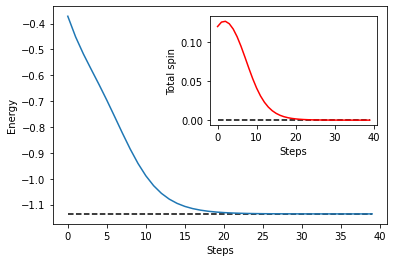

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

theory_energy = -1.136189454088
theory_spin = 0

plt.hlines(theory_energy, 0, 39, linestyles="dashed", colors="black")
plt.plot(energies)
plt.xlabel("Steps")
plt.ylabel("Energy")

axs = plt.gca()

inset = inset_axes(axs, width="50%", height="50%", borderpad=1)
inset.hlines(theory_spin, 0, 39, linestyles="dashed", colors="black")
inset.plot(spins, "r")
inset.set_xlabel("Steps")
inset.set_ylabel("Total spin");

ここまでで、Pennylane/Braket パイプラインを使用して、分子の基底状態エネルギーを効率的に見つける方法を学びました！

## `shots>0` での VQE の実行

上記の例では、ハミルトニアンの厳密な期待値計算を、それぞれ1回の評価で行うことが可能でした。これはシミュレータが状態にアクセス可能であるためで、QPU のように測定により期待値を計算するデバイスの場合は不可能です。

電子ハミルトニアン ``h`` の期待値を有限回の測定から求めたいとします。このハミルトニアンは、パウリ作用素のテンソル積である15の個々のオブザーバブルから構成されます。

In [ ]:
print("Number of Pauli terms in h:", len(h.ops))

期待値を測定する簡単なアプローチは、回路を15回実装し、毎回ハミルトニアン ``h`` の一部を形成するパウリ項の1つを測定することです。しかし、もっと効率的な方法があるかもしれません。パウリ項は、単一の回路で同時に測定できるグループ（PennyLane の [グループ化](https://pennylane.readthedocs.io/en/stable/code/qml_grouping.html) モジュールを参照）に分けることができます。各グループの要素は、量子ビットごとに交換可能なオブザーバブルとして知られています。ハミルトニアン ``h`` は5つのグループに分けることができます:

In [ ]:
groups, coeffs = qml.grouping.group_observables(h.ops, h.coeffs)
print("Number of qubit-wise commuting groups:", len(groups))

実際には、これは15の別々の回路を実行する代わりに、5つを実行するだけで済むことを意味します。この節約は、ハミルトニアンのパウリ項の数が増えるにつれて、さらに顕著になります。例えば、より大きな分子または異なる化学的基底集合に切り替えると、量子ビット数と項数の両方が増加する可能性があります。

幸い、PennyLane/Braket パイプラインには、デバイスの実行回数を最小限に抑えるためにオブザーバブルを事前にグループ化するための機能が組み込まれており、リモートデバイスを使用するときの実行時間とシミュレーション料金の両方を節約できます。このチュートリアルの残りの部分では、最適化されたオブザーバブルのグループ化を使用します。

<div align="center"><img src="grouping.png"/></div>

グループ化の恩恵を受けるためには、PennyLane が各ハミルトニアンを量子ビットごとの可換なグループに分割するよう指示する必要があります。そのため、グルーピングを計算し、ハミルトニアンと保存します。デバイスは、回路を生成する際にこの情報を使います。

In [ ]:
h.compute_grouping()
S2.compute_grouping()

次に、非ゼロの `shots` を指定してデバイスをインスタンス化します。

In [ ]:
dev = qml.device("braket.local.qubit", wires=qubits, shots=1000)

コスト関数を再定義します。

In [ ]:
wires = dev.wires.tolist()

@qml.qnode(dev)
def energy_expval(params):
    circuit(params, wires)
    return qml.expval(h)

@qml.qnode(dev)
def S2_expval(params):
    circuit(params, wires)
    return qml.expval(S2)

def spin(params):
    return -0.5 + np.sqrt(1 / 4 + S2_expval(params))

最後に、VQE の実験を行い期待値を推定します。

In [ ]:
energies, spins = run_vqe(energy_expval, spin, opt, params, iterations)

厳密な計算と非常に近い値が得られました！この実験では Local Simulator を使いましたが、同じことが QPU やショット数を非ゼロとした他のシミュレータでも実行できます。

<div class="alert alert-block alert-info">
<b>次のステップは？</b> <code>qchem</code> フォルダには、水素分子の異なる原子間距離を表す追加の分子構造ファイルが含まれています。原子間距離の 1 つを選択し、基底状態のエネルギーを求めましょう。原子間距離によって基底状態のエネルギーはどのように変化するでしょう？ 
</div>